#**Data Spaces**
###**Matteo Stoisa**

In [1]:
#IMPORT LIBRARIES 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; 
from google.colab import drive
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#MOUNT GDRIVE
drive.mount('/content/gdrive', force_remount=True)
%cd gdrive/MyDrive/Colab Notebooks/
dataset_path = "/content/gdrive/MyDrive/Colab Notebooks/the-spotify-hit-predictor-dataset/dataset-of-10s.csv"

#GIT PULL DATASET
! git clone https://github.com/fortytwo102/the-spotify-hit-predictor-dataset
! git pull

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks
fatal: destination path 'the-spotify-hit-predictor-dataset' already exists and is not an empty directory.
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


###*SETUP DATASET AND SPLITS:*


In [2]:
whole_dataset = pd.read_csv(dataset_path, delimiter=",") 

#EXTRACT 'featuring' FEATURE
artists = whole_dataset.loc[:, 'artist']
withFeaturing = []
for artist in artists:
  if "Featuring" in artist or " & " in artist:
    withFeaturing.append(1)
  else:
    withFeaturing.append(0)
whole_dataset['featuring'] = withFeaturing

#NORMALIZATION
scaler = preprocessing.MinMaxScaler()
features_to_scale = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit', 'sections']
whole_dataset_unnormalized = whole_dataset.copy()
whole_dataset[features_to_scale] = scaler.fit_transform(whole_dataset[features_to_scale])

#DEFINE FEATURE TYPES
whole_features = list(whole_dataset.columns.values)
secondary_features = ['track', 'artist', 'uri']
discrete_features = ['key', 'duration_ms','time_signature', 'sections']
boolean_features = ['mode', 'featuring']
primary_features = []
continuous_features = []
for feature in whole_features:
  if feature not in secondary_features:
    primary_features.append(feature)
    if feature not in discrete_features and feature not in boolean_features:
      continuous_features.append(feature)
primary_features.remove('target')
continuous_features.remove('target')

#SPLIT DATASET
dataset = whole_dataset.drop(columns = secondary_features)
dataset_labels = dataset.loc[:, 'target']
dataset_and_labels = dataset.copy()
dataset = dataset.drop(columns='target')
dataset_0 = whole_dataset.loc[whole_dataset['target'] == 0]
dataset_1 = whole_dataset.loc[whole_dataset['target'] == 1]
dataset_0 = dataset_0.drop(columns=secondary_features)
dataset_0 = dataset_0.drop(columns='target')
dataset_1 = dataset_1.drop(columns=secondary_features)
dataset_1 = dataset_1.drop(columns='target')

#TRAIN-TEST SPLIT
x_train, x_test, y_train, y_test = train_test_split(dataset, dataset_labels, test_size=0.2, stratify=dataset_labels, random_state=15)

###*DATASET:* 


In [3]:
whole_dataset_unnormalized.head(5)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,featuring
0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1,-4.826,0,0.0886,0.02000,0.000,0.0828,0.706,108.029,188493,4,41.18681,10,1,0
1,Surfboard,Esquivel!,spotify:track:61APOtq25SCMuK0V5w2Kgp,0.447,0.247,5,-14.661,0,0.0346,0.87100,0.814,0.0946,0.250,155.489,176880,3,33.18083,9,0,0
2,Love Someone,Lukas Graham,spotify:track:2JqnpexlO9dmvjUMCaLCLJ,0.550,0.415,9,-6.557,0,0.0520,0.16100,0.000,0.1080,0.274,172.065,205463,4,44.89147,9,1,0
3,Music To My Ears (feat. Tory Lanez),Keys N Krates,spotify:track:0cjfLhk8WJ3etPTCseKXtk,0.502,0.648,0,-5.698,0,0.0527,0.00513,0.000,0.2040,0.291,91.837,193043,4,29.52521,7,0,0
4,Juju On That Beat (TZ Anthem),Zay Hilfigerrr & Zayion McCall,spotify:track:1lItf5ZXJc1by9SbPeljFd,0.807,0.887,1,-3.892,1,0.2750,0.00381,0.000,0.3910,0.780,160.517,144244,4,24.99199,8,1,1


In [4]:
dataset.head(5)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,featuring
0,0.738790,0.626533,0.090909,0.899432,0,0.070809,0.020080,0.00000,0.068476,0.723361,0.400098,0.093080,0.8,0.193225,0.093023,0
1,0.418807,0.247058,0.454545,0.687954,0,0.012962,0.874498,0.81809,0.080700,0.256148,0.676658,0.086266,0.6,0.155665,0.081395,0
2,0.530910,0.415269,0.818182,0.862211,0,0.031601,0.161647,0.00000,0.094582,0.280738,0.773251,0.103036,0.8,0.210605,0.081395,0
3,0.478668,0.648560,0.000000,0.880682,0,0.032351,0.005151,0.00000,0.194033,0.298156,0.305743,0.095749,0.8,0.138515,0.058140,0
4,0.810623,0.887860,0.090909,0.919516,1,0.270487,0.003825,0.00000,0.387755,0.799180,0.705958,0.067117,0.8,0.117248,0.069767,1


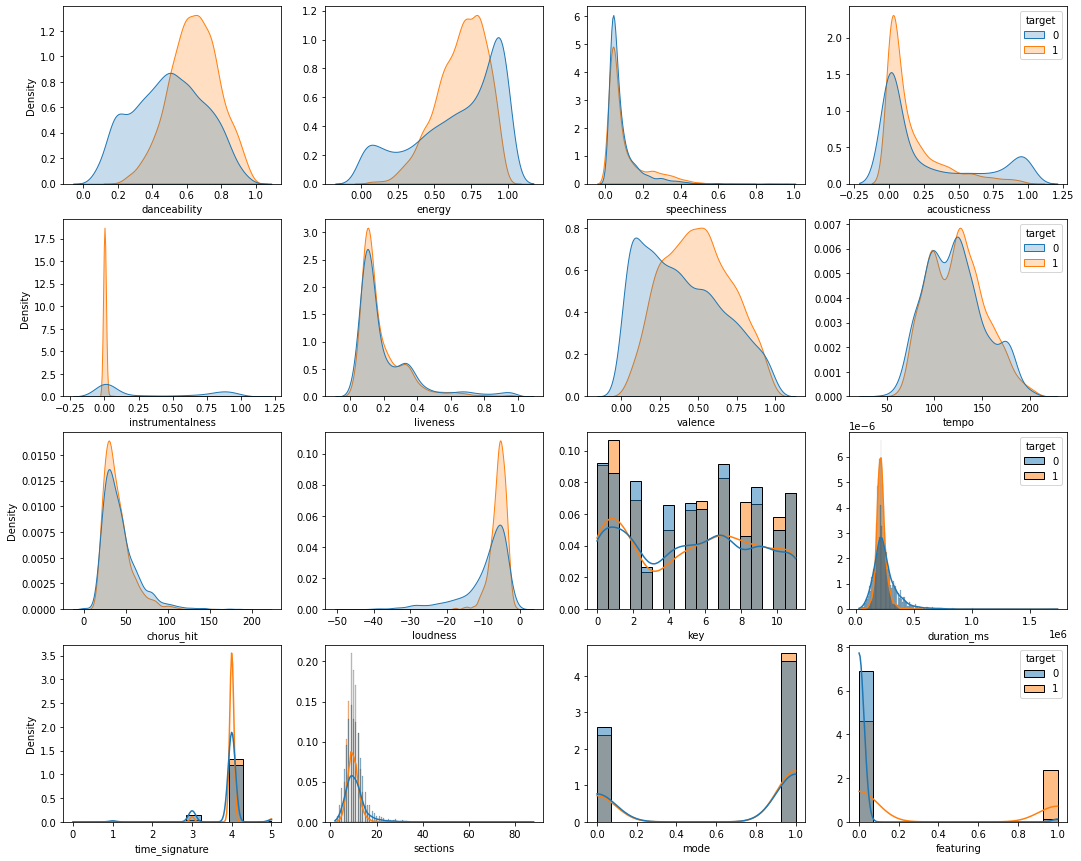

In [5]:
#VISUALIZE DISTRIBUTION DENSITY OF FEATURES PER TARGET
def plot_dataset_distribution(ds):
  fig, axes = plt.subplots(4, 4, figsize=(18, 15))
  num=0
  for column in ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']:
    sns.kdeplot(ax=axes[int(num/4), num%4], data=ds, x=column, hue="target", fill=True, legend=(num in range(3,17,4)))
    if num not in range(0,17,4):
      axes[int(num/4), num%4].yaxis.label.set_visible(False)
    num += 1
  for column in ['tempo', 'chorus_hit', 'loudness']:
    sns.kdeplot(ax=axes[int(num/4), num%4], data=ds, x=column, hue="target", fill=True, legend=(num in range(3,17,4)))
    if num not in range(0,17,4):
      axes[int(num/4), num%4].yaxis.label.set_visible(False)
    num += 1
  for column in discrete_features: 
    sns.histplot(ax=axes[int(num/4), num%4], data=ds, x=column, hue="target", stat="density", kde=True, legend=(num in range(3,17,4)))
    if num not in range(0,17,4):
      axes[int(num/4), num%4].yaxis.label.set_visible(False)
    num += 1
  for column in boolean_features: 
    sns.histplot(ax=axes[int(num/4), num%4], data=ds, x=column, hue="target", stat="density", kde=True, legend=(num in range(3,17,4)))
    if num not in range(0,17,4):
      axes[int(num/4), num%4].yaxis.label.set_visible(False)
    num += 1
  plt.show()

plot_dataset_distribution(whole_dataset_unnormalized)

###*CORRELATION:*

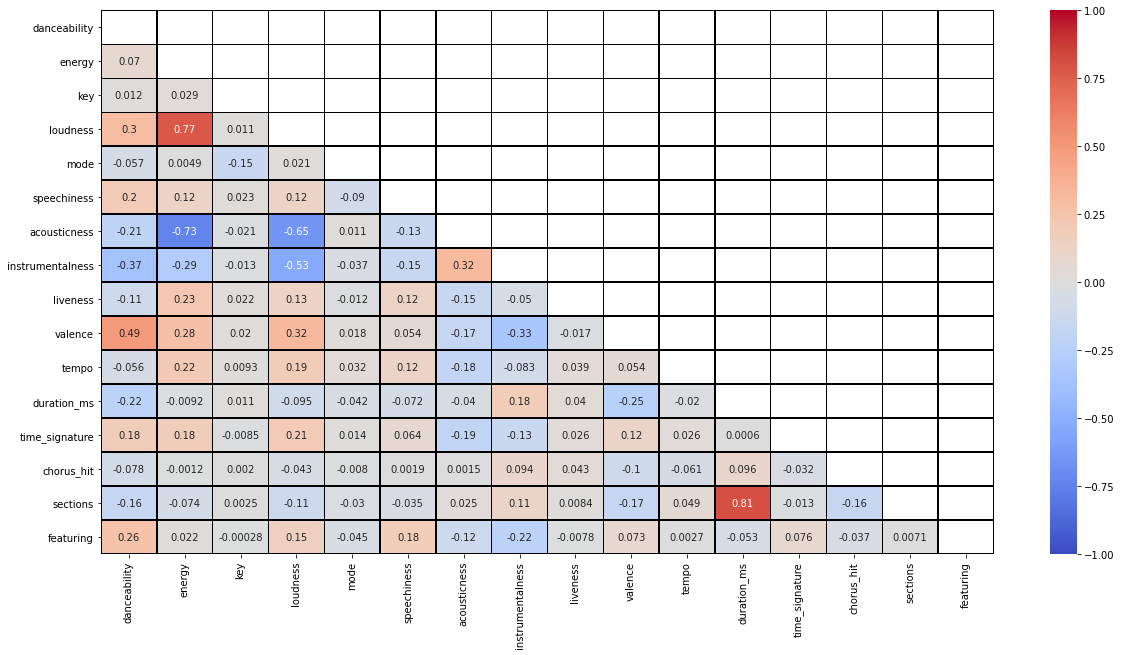


POSITIVE CORRELATION MEAN:  0.11807701987116528  (52.5 %)
NEGATIVE CORRELATION MEAN: -0.1269603112866643 (47.5 %)


In [6]:
correlation_matrix = dataset.corr()
plt.figure(figsize=(20, 10))
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlation_matrix, annot=True, fmt='.2g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=0.5, linecolor='black', mask=mask)
plt.show()
positive_count = 0
negative_count = 0
positive_sum = 0
negative_sum = 0
for i in range(1, len(correlation_matrix)):
  for j in range(i):
    if correlation_matrix.iloc[i, j] > 0:
      positive_count += 1
      positive_sum += correlation_matrix.iloc[i, j]
    else:
      negative_count += 1
      negative_sum += correlation_matrix.iloc[i, j]

print("\nPOSITIVE CORRELATION MEAN:  {}  ({} %)".format(positive_sum / positive_count, (positive_count / (positive_count + negative_count)) * 100))
print("NEGATIVE CORRELATION MEAN: {} ({} %)".format(negative_sum / negative_count, (negative_count / (positive_count + negative_count)) * 100))

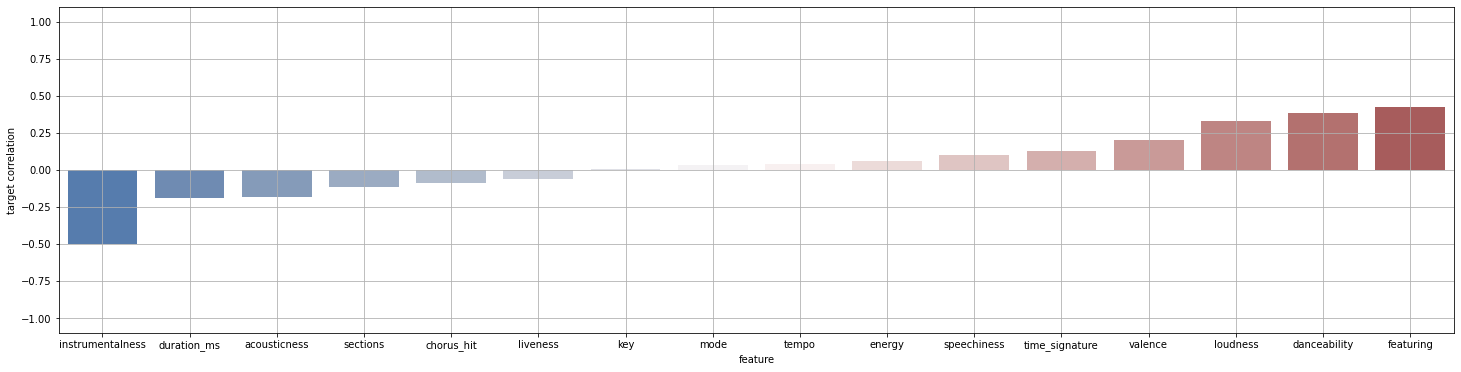


POSITIVE CORRELATION MEAN:  0.17011518360189729  (62.5 %)
NEGATIVE CORRELATION MEAN: -0.18914825072033462 (37.5 %)


In [7]:
plt.figure(figsize=(25, 6))
correlation_target = whole_dataset.corr().loc[primary_features , 'target']
corrDf = pd.DataFrame()
corrDf['col'] = primary_features
corrDf['corr'] = correlation_target.values
corrDf = corrDf.sort_values(by='corr')

sns.barplot(x=corrDf['col'], y=corrDf['corr'], palette="vlag")
plt.ylim(-1.1, 1.1)
plt.grid(True)
plt.xlabel('feature')
plt.ylabel('target correlation')
plt.show()

positive_count = 0
negative_count = 0
positive_sum = 0
negative_sum = 0
for num in correlation_target:
  if num > 0:
    positive_count += 1
    positive_sum += num
  else:
    negative_count += 1
    negative_sum += num

print("\nPOSITIVE CORRELATION MEAN:  {}  ({} %)".format(positive_sum / positive_count, (positive_count / len(primary_features)) * 100))
print("NEGATIVE CORRELATION MEAN: {} ({} %)".format(negative_sum / negative_count, (negative_count / len(primary_features)) * 100))

###*BOXPLOTS:*

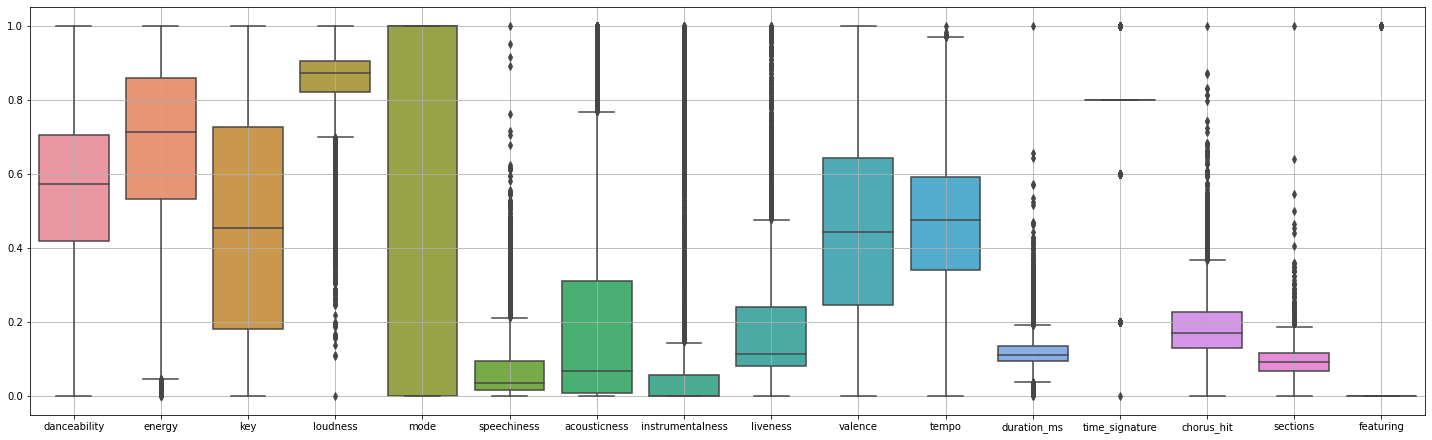

In [8]:
fig = plt.figure(figsize=(25, 7.5))
ax = sns.boxplot(data=dataset)
plt.grid(True)
plt.show()

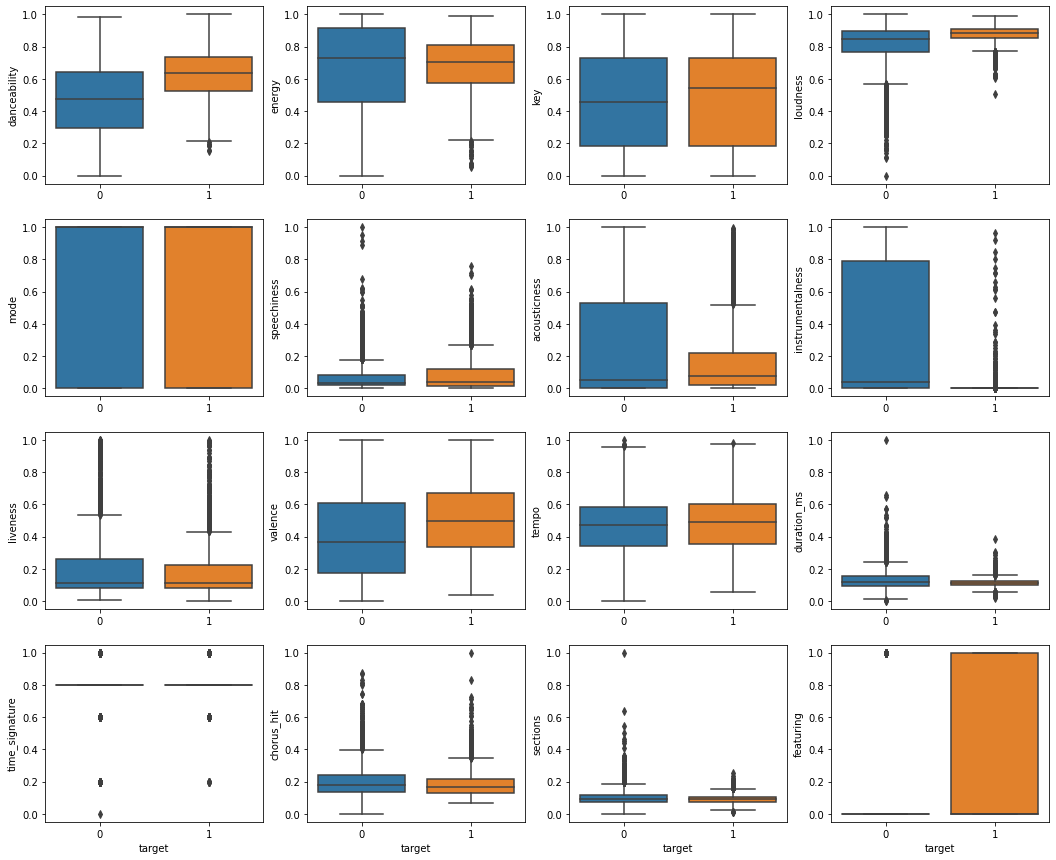

In [149]:
#BOXPLOT PER FEATURE GROUPED BY TARGET
def plot_dataset_boxplots(ds, dsl=True):
  if dsl is True:
    fig, axes = plt.subplots(4, 4, figsize=(18, 15))
    num=0
    for column in primary_features:
      sns.boxplot(ax=axes[int(num/4), num%4], data=ds, x='target', y=column)
      if num < 12:
        axes[int(num/4), num%4].xaxis.label.set_visible(False)
      num+=1
    plt.show()
  else:
    fig, axes = plt.subplots(4, 4, figsize=(18, 15))
    tmp = ds.copy()
    tmp['target'] = dsl.values
    num=0
    for column in primary_features:
      sns.boxplot(ax=axes[int(num/4), num%4], data=tmp, x='target', y=column)
      if num < 12:
        axes[int(num/4), num%4].xaxis.label.set_visible(False)
      num+=1
    plt.show()

plot_dataset_boxplots(whole_dataset)

###*PRINCIPAL COMPONENT ANALISYS:*

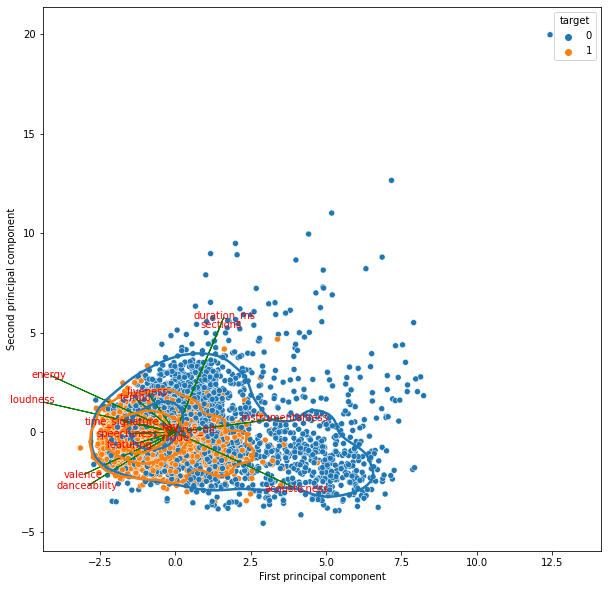

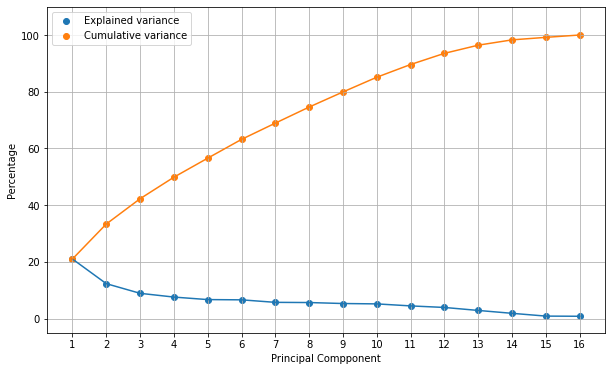

In [128]:
def plot_pca(ds, dsl, plot_variance=True):  
  #CALCULATE PCA
  scaler = StandardScaler()
  scaler.fit(ds[primary_features])
  X=scaler.transform(ds[primary_features])    
  pca = PCA()
  x_pca = pca.fit_transform(X)

  #FILL PCA DATAFRAME
  columns = []
  for i in range(len(primary_features)):
    columns.append("PC{}".format(i+1))
  PCAdf = pd.DataFrame(data = x_pca, columns = columns)
  PCAdf['target'] = dsl.values

  #PRINT FIRST 2 PC
  plt.figure(figsize = (10,10))
  plt.xlabel("First principal component")
  plt.ylabel("Second principal component")
  sns.kdeplot(data=PCAdf, x='PC1', y='PC2', hue="target", levels=4, linewidths=2.5)
  sns.scatterplot(data=PCAdf, x='PC1', y='PC2', hue="target")
  for i in range(len(primary_features)):
    plt.arrow(0, 0, pca.components_.T[i,0] * 10, pca.components_.T[i,1] * 10,color = 'g')
    plt.text(pca.components_.T[i,0]* 10.15, pca.components_.T[i,1] * 10.15, primary_features[i], color = 'r', ha = 'center', va = 'center')
  plt.show()

  #PLOT VARIANCE 
  if plot_variance:
    plt.figure(figsize=(10, 6))
    variance_ratio = pca.explained_variance_ratio_
    xticks = np.arange(16) + 1
    plt.grid(True)
    plt.xticks(xticks)
    plt.ylim(-5, 110)
    plt.ylabel('Percentage')
    plt.xlabel('Principal Compponent')
    plt.scatter(xticks, variance_ratio * 100, label='Explained variance')
    plt.plot(xticks, variance_ratio * 100)
    plt.scatter(xticks, np.cumsum(variance_ratio) * 100, label='Cumulative variance')
    plt.plot(xticks, np.cumsum(variance_ratio) * 100)
    plt.legend()
    plt.show()

plot_pca(dataset, dataset_labels)

###*IQR OUTLIERS:*

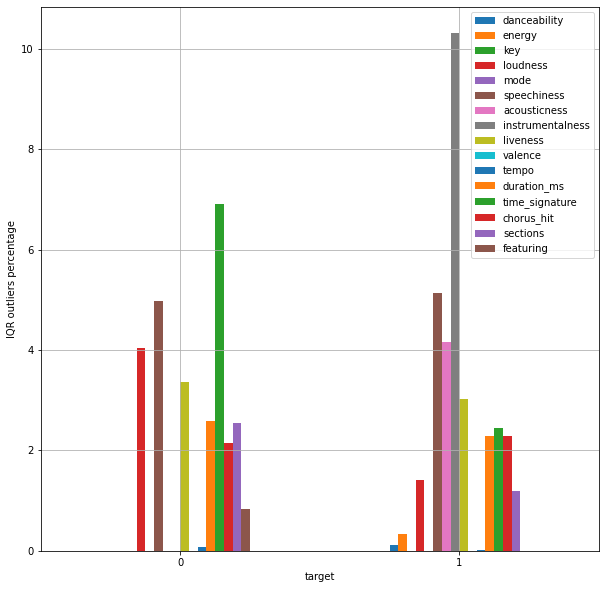


MEAN IQR OUTLIERS PERCENTAGE TARGET 0: 1.717333541731791 %
MEAN IQR OUTLIERS PERCENTAGE TARGET 1: 2.044584245076586 %


In [11]:
clean_dataset = dataset_0.copy()
outliers_dataset_0 = []
for feature in primary_features:
  clean_dataset=clean_dataset.sort_values(by=feature)
  q1, q3= np.percentile(clean_dataset[feature],[25,75])
  iqr=q3-q1
  lower_bound = q1 - (1.5 * iqr)
  upper_bound = q3 + (1.5 * iqr) 
  if lower_bound is not 0 or upper_bound is not 1:
    count_outliers=len(clean_dataset.loc[(clean_dataset[feature] < lower_bound)])
    count_outliers+=len(clean_dataset.loc[(clean_dataset[feature] > upper_bound)])
    outliers_dataset_0.append(count_outliers)
  else:
    outliers_dataset_0.append(0)

clean_dataset = dataset_1.copy()
outliers_dataset_1 = []
for feature in primary_features:
  clean_dataset=clean_dataset.sort_values(by=feature)
  q1, q3= np.percentile(clean_dataset[feature],[25,75])
  iqr=q3-q1
  lower_bound = q1 - (1.5 * iqr)
  upper_bound = q3 + (1.5 * iqr) 
  if lower_bound is not 0 or upper_bound is not 1:
    count_outliers=len(clean_dataset.loc[(clean_dataset[feature] < lower_bound)])
    count_outliers+=len(clean_dataset.loc[(clean_dataset[feature] > upper_bound)])
    outliers_dataset_1.append(count_outliers)
  else:
    outliers_dataset_1.append(0)

def count_IQR_outliers(ds_0, ds_1):
  ds_0 = np.asarray(ds_0) * (100 / len(dataset))
  ds_1 = np.asarray(ds_1) * (100 / len(dataset))
  outliers = pd.DataFrame([ds_0, ds_1], columns=primary_features)
  outliers.plot.bar(xlabel='target', ylabel='IQR outliers percentage', figsize=(10, 10), rot=0)
  plt.grid(True)
  plt.show()

  print('\nMEAN IQR OUTLIERS PERCENTAGE TARGET 0: {} %'.format(ds_0.sum() / len(ds_0)))
  print('MEAN IQR OUTLIERS PERCENTAGE TARGET 1: {} %'.format(ds_1.sum() / len(ds_1)))     

count_IQR_outliers(outliers_dataset_0, outliers_dataset_1) 

In [151]:
cumulative_median_distance = np.zeros(len(dataset))
feature_outlier_percentage = np.zeros(len(dataset))
cumulative_median_distance_separate = np.zeros(len(dataset))
for feature in primary_features:
  q1, q3= np.percentile(dataset_0[feature],[25,75])
  iqr=q3-q1
  lower_bound_0 = q1 - (1.5 * iqr)
  upper_bound_0 = q3 + (1.5 * iqr)
  median_0 = np.median(dataset_0[feature])
  q1, q3= np.percentile(dataset_1[feature],[25,75])
  iqr=q3-q1
  lower_bound_1 = q1 - (1.5 * iqr)
  upper_bound_1 = q3 + (1.5 * iqr)
  median_1 = np.median(dataset_1[feature])
  for idx, value in enumerate(dataset[feature]):
    if dataset_and_labels.loc[idx]['target'] == 0:
      score = np.abs(value - median_0)
      cumulative_median_distance[idx] += score
      score = np.abs(value - median_1)
      cumulative_median_distance_separate[idx] -= 2 * score
      if value < lower_bound_0 or value > upper_bound_0:
        feature_outlier_percentage[idx] += 1
    else:
      score = np.abs(value - median_1)
      cumulative_median_distance[idx] += score
      score = np.abs(value - median_0)
      cumulative_median_distance_separate[idx] -= 2 * score
      if value < lower_bound_1 or value > upper_bound_1:
        feature_outlier_percentage[idx] += 1
dataset_and_labels['cumulative_median_distance'] = cumulative_median_distance
dataset_and_labels['feature_outlier_percentage'] = feature_outlier_percentage * (100 / len(primary_features))
dataset_and_labels['cumulative_median_distance_separate'] = cumulative_median_distance_separate

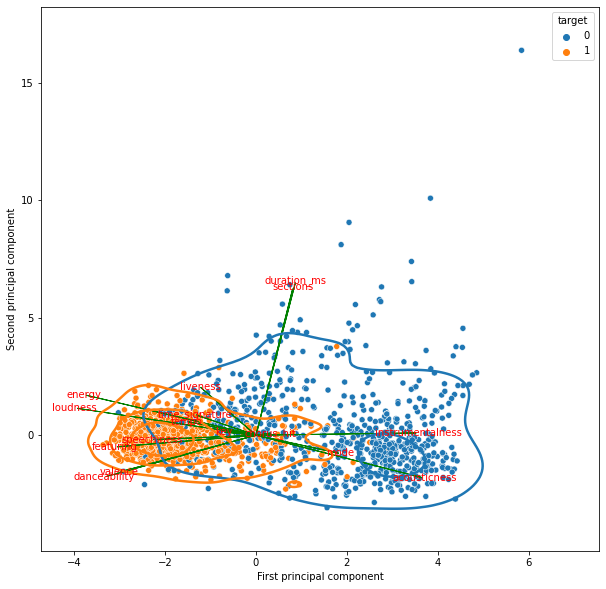

In [159]:
def drop_by(ds, drop_percentace, by):
  rank_indexes = ds.sort_values(by=by).index
  count_to_delete_0 = count_to_delete_1 = int(len(ds) * (drop_percentace / 200))
  to_delete = []
  for idx in reversed(rank_indexes):
    if ds.loc[idx]['target'] == 0:
      if count_to_delete_0 != 0:
        to_delete.append(idx)
        count_to_delete_0 -= 1
    else:
      if count_to_delete_1 != 0:
        to_delete.append(idx)
        count_to_delete_1 -= 1
    if count_to_delete_0 == 0 and count_to_delete_1 == 0:
      break
  return to_delete

#dropped_median_distance = dataset.drop(drop_by(dataset_and_labels, 20, 'cumulative_median_distance'))
#dropped_feature_percentage = dataset.drop(drop_by(dataset_and_labels, 20, 'feature_outlier_percentage'))
dropped_median_distance_separate = dataset.drop(drop_by(dataset_and_labels, 75, 'cumulative_median_distance_separate'))

#plot_pca(dropped_median_distance[primary_features], dataset_labels.loc[dropped_median_distance.index], False)
#plot_pca(dropped_feature_percentage[primary_features], dataset_labels.loc[dropped_feature_percentage.index], False)
plot_pca(dropped_median_distance_separate[primary_features], dataset_labels.loc[dropped_median_distance_separate.index], False)

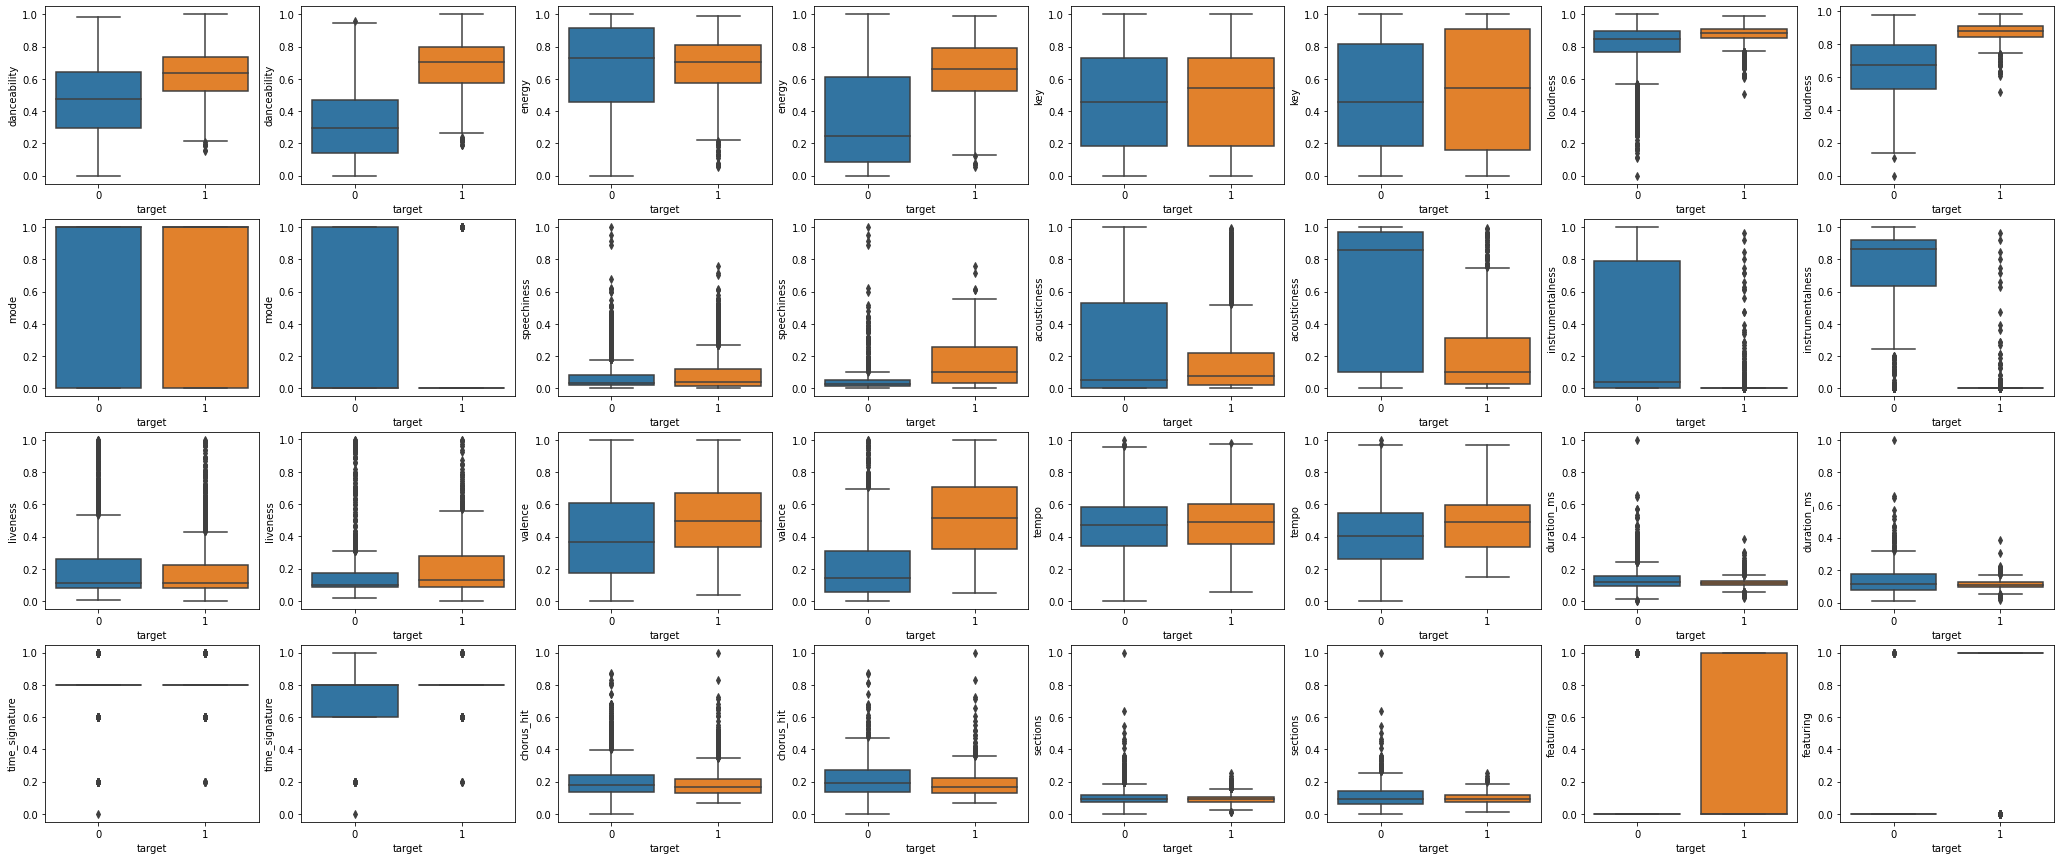

In [160]:
dropped_median_distance_separate['target'] = dataset_labels.loc[dropped_median_distance_separate.index].values

fig, axes = plt.subplots(4, 8, figsize=(36, 15))
num=0
for column in primary_features:
  sns.boxplot(ax=axes[int(num/8), num%8], data=whole_dataset, x='target', y=column)
  num+=1
  sns.boxplot(ax=axes[int(num/8), num%8], data=dropped_median_distance_separate, x='target', y=column)
  #if num < 12:
    #axes[int(num/4), num%4].xaxis.label.set_visible(False)
  num+=1
plt.show()

In [55]:
dataset_0['score_0'] = score(dataset_0)
dataset_1['score_1'] = score(dataset_1)
dataset_0 = dataset_0.sort_values(by='score_0')
dataset_1 = dataset_1.sort_values(by='score_1')

pre_0 = dataset_0['score_0'].to_numpy()
pre_1 = dataset_1['score_1'].to_numpy()

dropped_dataset_0 = dataset_0.drop(dataset_0.tail(int(len(dataset_0) * 0.2)).index)
dropped_dataset_1 = dataset_1.drop(dataset_1.tail(int(len(dataset_1) * 0.2)).index)
fig = plt.figure(figsize=(15, 5))
plt.plot(pre_0, label='dropped score_0')
plt.plot(pre_1, label='dropped score_1')
plt.plot(dropped_dataset_0['score_0'].to_numpy(), label='score_0')
plt.plot(dropped_dataset_1['score_1'].to_numpy(), label='score_1')
plt.legend()
plt.grid(True)
plt.show()

indexes_to_drop = dataset_0.tail(int(len(dataset_0) * 0.2)).index
indexes_to_drop = indexes_to_drop.append(dataset_1.tail(int(len(dataset_1) * 0.2)).index)
dropped_dataset_score = dataset.drop(indexes_to_drop)
dropped_labels_score = dataset_labels.drop(indexes_to_drop)

x_train_dropped_score, x_test_dropped_score, y_train_dropped_score, y_test_dropped_score = train_test_split(dropped_dataset_score, dropped_labels_score, test_size=0.2, stratify=dropped_labels_score, random_state=15)

TypeError: ignored

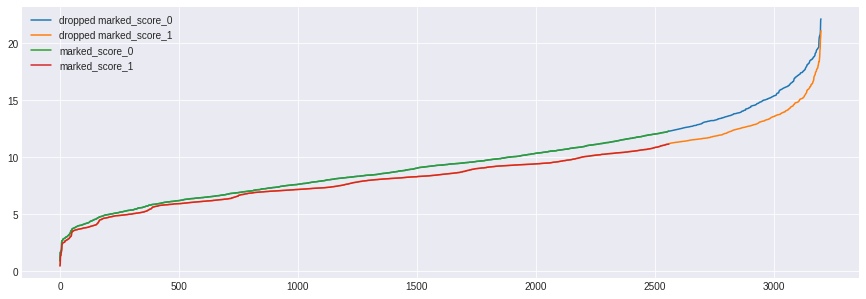

In [ ]:
dataset_0['marked_score_0'] = marked_score(dataset_0)
dataset_1['marked_score_1'] = marked_score(dataset_1)
dataset_0 = dataset_0.sort_values(by='marked_score_0')
dataset_1 = dataset_1.sort_values(by='marked_score_1')

pre_0 = dataset_0['marked_score_0'].to_numpy()
pre_1 = dataset_1['marked_score_1'].to_numpy()

dropped_dataset_0 = dataset_0.drop(dataset_0.tail(int(len(dataset_0) * 0.2)).index)
dropped_dataset_1 = dataset_1.drop(dataset_1.tail(int(len(dataset_1) * 0.2)).index)
fig = plt.figure(figsize=(15, 5))
plt.plot(pre_0, label='dropped marked_score_0')
plt.plot(pre_1, label='dropped marked_score_1')
plt.plot(dropped_dataset_0['marked_score_0'].to_numpy(), label='marked_score_0')
plt.plot(dropped_dataset_1['marked_score_1'].to_numpy(), label='marked_score_1')
plt.legend()
plt.grid(True)
plt.show()

indexes_to_drop_marked = dataset_0.tail(int(len(dataset_0) * 0.2)).index
indexes_to_drop_marked = indexes_to_drop.append(dataset_1.tail(int(len(dataset_1) * 0.2)).index)
dropped_dataset_marked_score = dataset.drop(indexes_to_drop_marked)
dropped_labels_marked_score = dataset_labels.drop(indexes_to_drop_marked)

x_train_dropped_marked_score, x_test_dropped_marked_score, y_train_dropped_marked_score, y_test_dropped_marked_score = train_test_split(dropped_dataset_marked_score, dropped_labels_marked_score, test_size=0.2, stratify=dropped_labels_marked_score, random_state=15)

###*LOGISTIC REGRESSION:*

WHOLE DATASET
Best validation: 0.821224 using {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Test score: 0.803125


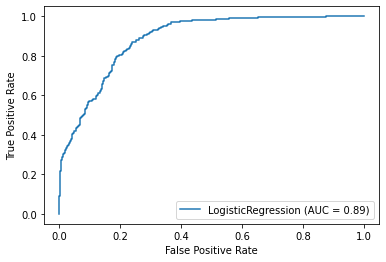

In [85]:
model = LogisticRegression(max_iter=200)
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['none', 'l1', 'l2', 'elasticnet']
c_values = [0.001, 0.01, 1, 10, 100]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=8, 
                           scoring='accuracy',
                           error_score=0)
grid_result = grid_search.fit(x_train, y_train)
print("WHOLE DATASET")
print("Best validation: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Test score: %f" % metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test))
metrics.plot_roc_curve(grid_result.best_estimator_, x_test, y_test) 
plt.show()

WHOLE DATASET
Best validation: 0.820249 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Test score: 0.807813


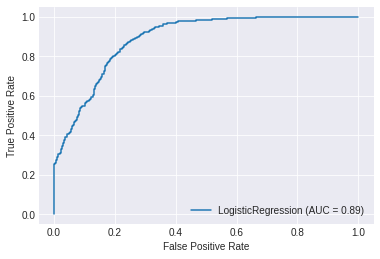

DATASET DROPPED BY SCORE
Best validation: 0.792955 using {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Test score: 0.791016


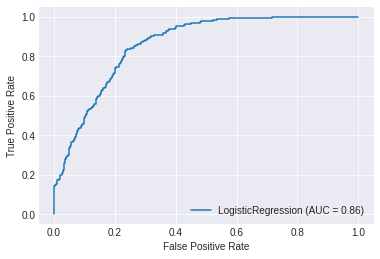

DATASET DROPPED BY MARKED SCORE
Best validation: 0.803700 using {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Test score: 0.831055


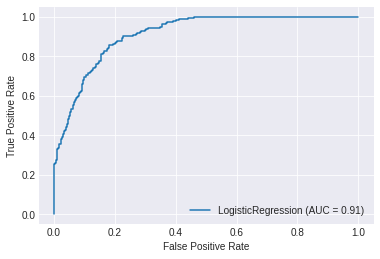

In [ ]:
model = LogisticRegression(max_iter=200)
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['none', 'l1', 'l2', 'elasticnet']
c_values = [0.001, 0.01, 1, 10, 100]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=10, 
                           scoring='accuracy',
                           error_score=0)

grid_result = grid_search.fit(x_train, y_train)
print("WHOLE DATASET")
print("Best validation: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Test score: %f" % metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test))
metrics.plot_roc_curve(grid_result.best_estimator_, x_test, y_test) 
plt.show()

model = LogisticRegression(max_iter=200)
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['none', 'l1', 'l2', 'elasticnet']
c_values = [0.001, 0.01, 1, 10, 100]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=10, 
                           scoring='accuracy',
                           error_score=0)

grid_result = grid_search.fit(x_train_dropped_score, y_train_dropped_score)
print("DATASET DROPPED BY SCORE")
print("Best validation: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Test score: %f" % metrics.accuracy_score(grid_result.best_estimator_.predict(x_test_dropped_score), y_test_dropped_score))
metrics.plot_roc_curve(grid_result.best_estimator_, x_test_dropped_score, y_test_dropped_score) 
plt.show()

model = LogisticRegression(max_iter=200)
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['none', 'l1', 'l2', 'elasticnet']
c_values = [0.001, 0.01, 1, 10, 100]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=10, 
                           scoring='accuracy',
                           error_score=0)

grid_result = grid_search.fit(x_train_dropped_marked_score, y_train_dropped_marked_score)
print("DATASET DROPPED BY MARKED SCORE")
print("Best validation: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Test score: %f" % metrics.accuracy_score(grid_result.best_estimator_.predict(x_test_dropped_marked_score), y_test_dropped_marked_score))
metrics.plot_roc_curve(grid_result.best_estimator_, x_test_dropped_marked_score, y_test_dropped_marked_score) 
plt.show()

In [ ]:
model = LogisticRegression(max_iter=200)
solvers = ['lbfgs']
penalty = ['l2']
c_values = range(1, 100, 1)

grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=5, 
                           scoring='accuracy',
                           error_score=0)
grid_result = grid_search.fit(x_train, y_train)

print("Best validation: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Test score: %f" % metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test))

Best validation: 0.821416 using {'C': 13, 'penalty': 'l2', 'solver': 'lbfgs'}
Test score: 0.808594


In [ ]:
model = LogisticRegression(max_iter=200)solvers = ['lbfgs']
penalty = ['l2']
c_values = np.arange(5, 25, 1)

grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=5, 
                           scoring='accuracy',
                           error_score=0)
grid_result = grid_search.fit(x_train, y_train)

print("Best validation: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Test score: %f" % metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test))

Best validation: 0.821416 using {'C': 13, 'penalty': 'l2', 'solver': 'lbfgs'}
Test score: 0.808594


In [ ]:
model = LogisticRegression(max_iter=200)
solvers = ['lbfgs']
penalty = ['l2']
c_values = np.arange(12, 14, 0.025)

grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=5, 
                           scoring='accuracy',
                           error_score=0)
grid_result = grid_search.fit(x_train, y_train)

print("Best validation: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Test score: %f" % metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test))

Best validation: 0.807547 using {'C': 12.025, 'penalty': 'l2', 'solver': 'lbfgs'}
Test score: 0.803906


In [ ]:
#dropped score
model = LogisticRegression(max_iter=200)
solvers = ['lbfgs']
penalty = ['l2']
c_values = np.arange(5, 20, 0.025)

grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=5, 
                           scoring='accuracy',
                           error_score=0)
grid_result = grid_search.fit(x_train_dropped_score, y_train_dropped_score)

print("Best validation: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Test score: %f" % metrics.accuracy_score(grid_result.best_estimator_.predict(x_test_dropped_score), y_test_dropped_score))

Best validation: 0.789545 using {'C': 13.100000000000115, 'penalty': 'l2', 'solver': 'lbfgs'}
Test score: 0.792969


In [ ]:
#dropped marked score
model = LogisticRegression(max_iter=200)
solvers = ['lbfgs']
penalty = ['l2']
c_values = np.arange(5, 20, 0.025)

grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=5, 
                           scoring='accuracy',
                           error_score=0)
grid_result = grid_search.fit(x_train_dropped_marked_score, y_train_dropped_marked_score)

print("Best validation: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Test score: %f" % metrics.accuracy_score(grid_result.best_estimator_.predict(x_test_dropped_marked_score), y_test_dropped_marked_score))

NameError: ignored

###*KNN:*

In [ ]:
model = KNeighborsClassifier()
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']

grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=5, 
                           scoring='accuracy',
                           error_score=0)
grid_result = grid_search.fit(x_train, y_train)

print("Best validation: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Test score: %f" % metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test))

Best validation: 0.805004 using {'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}
Test score: 0.792188


In [ ]:
model = KNeighborsClassifier()
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']

grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=5, 
                           scoring='accuracy',
                           error_score=0)
grid_result = grid_search.fit(x_train_dropped, y_train_dropped)

print("Best validation: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Test score: %f" % metrics.accuracy_score(grid_result.best_estimator_.predict(x_test_dropped), y_test_dropped))

Best validation: 0.799802 using {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Test score: 0.796875


###*GAUSSIAN NAIVE BAYES:*

In [ ]:
model = GaussianNB()
var_smoothing = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

grid = dict(var_smoothing=var_smoothing)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=5, 
                           scoring='accuracy',
                           error_score=0)
grid_result = grid_search.fit(x_train, y_train)

print("Best validation: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Test score: %f" % metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test))

Best validation: 0.795823 using {'var_smoothing': 0.0001}
Test score: 0.789844


###*RANDOM FOREST:*

In [ ]:
model = RandomForestClassifier()

n_estimators = range(500, 1500, 100)
max_features = ['sqrt', 'log2']

grid = dict(n_estimators=n_estimators,max_features=max_features)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=5, 
                           scoring='accuracy',
                           error_score=0)
grid_result = grid_search.fit(x_train, y_train)

print("Best validation: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Test score: %f" % metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test))

Best validation: 0.859322 using {'max_features': 'log2', 'n_estimators': 700}
Test score: 0.852344


###*SUPPORT VECTOR MACHINE:*

In [ ]:
model = SVC()

kernel = ['poly', 'rbf', 'sigmoid']
C = range(1, 50, 1)
gamma = ['scale']

grid = dict(kernel=kernel,C=C,gamma=gamma)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, cv=5, 
                           scoring='accuracy',
                           error_score=0)
grid_result = grid_search.fit(x_train, y_train)

print("Best validation: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Test score: %f" % metrics.accuracy_score(grid_result.best_estimator_.predict(x_test), y_test))

Best validation: 0.842132 using {'C': 12, 'gamma': 'scale', 'kernel': 'poly'}
Test score: 0.828125


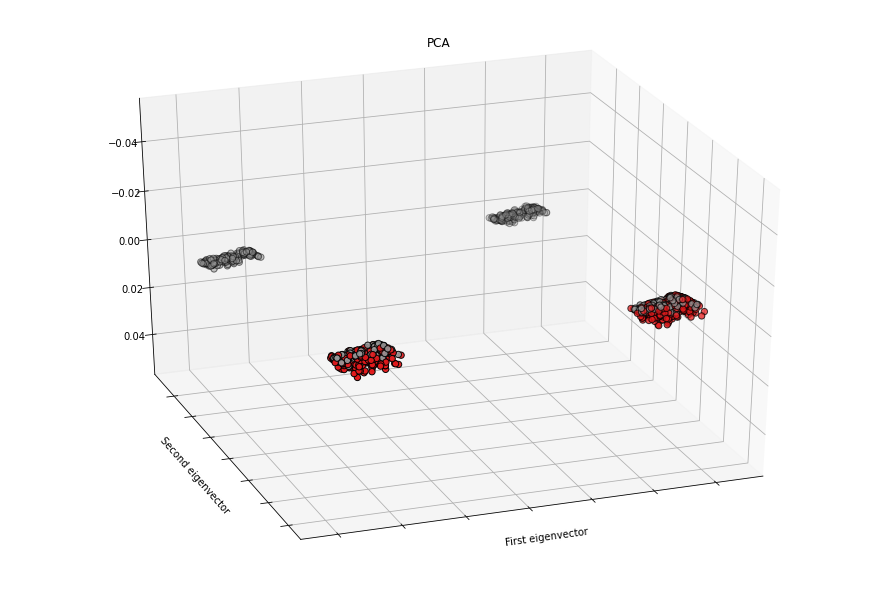

In [ ]:
fig = plt.figure(1, figsize=(12, 8))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=2).fit_transform(dropped)
ax.scatter(X_reduced[:, 0], 
          X_reduced[:, 1], 
          c=droppedy,
          cmap=plt.cm.Set1, 
          edgecolor='k', 
          s=40)
ax.set_title("PCA")
ax.set_xlabel("First eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("Second eigenvector")
ax.w_yaxis.set_ticklabels([])

plt.show()

/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [ ]:
for attribute in primary_attributes:
#  dataset.boxplot(column=attribute, by='target')
  plt.show()

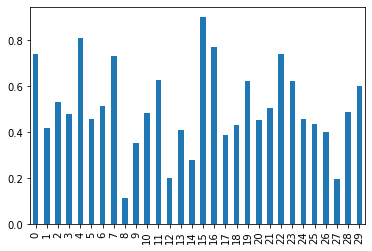

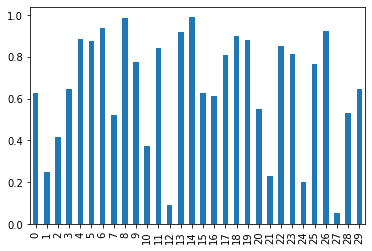

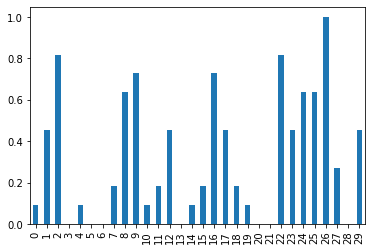

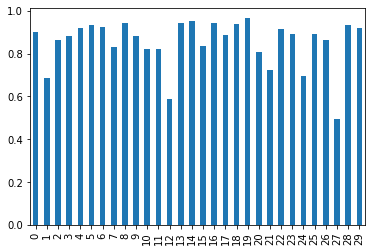

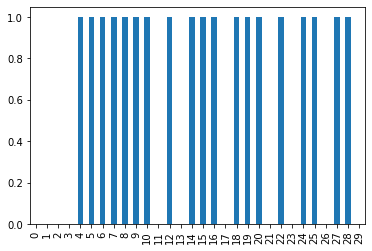

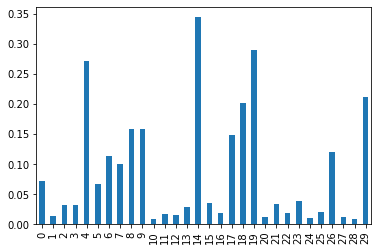

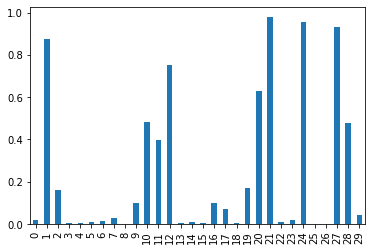

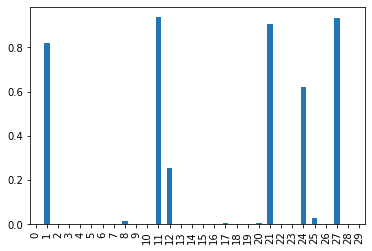

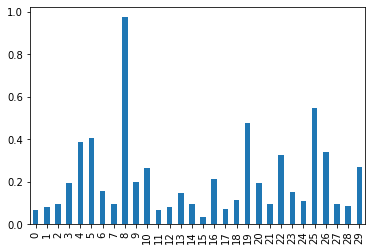

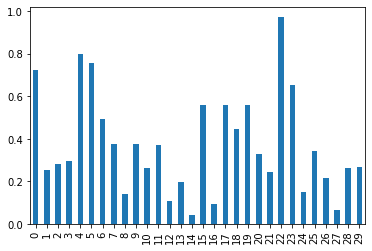

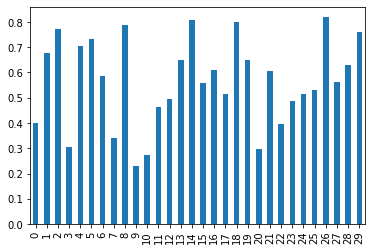

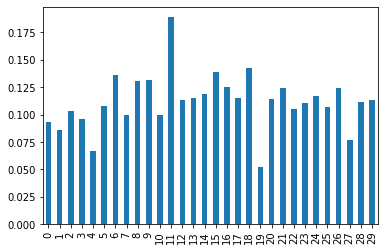

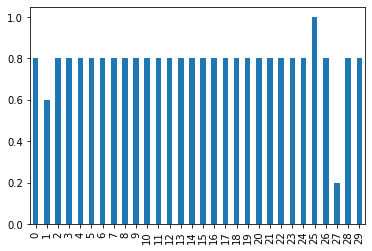

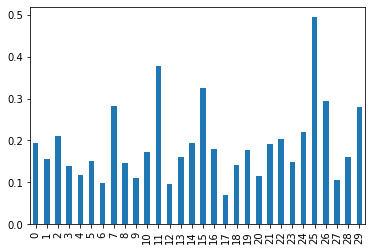

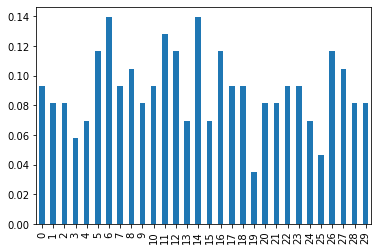

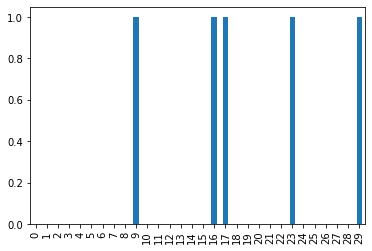

In [ ]:
for attribute in primary_attributes:
  #print("{}: 30 samples example\nglobl mean: {}, global variance:{}".format(attribute, dataset.loc[:,attribute].mean(), dataset.loc[:,attribute].var()))
  dataset[attribute].head(30).plot(kind='bar')
  plt.show()

In [ ]:
#TODO: da printare su uno stesso grafico in colori diversi su base target
'''
for attribute in dataset.columns.values:
  print(attribute + ":")
  dataset.plot(kind='scatter',x='id',y=attribute, color='green')
  dataset0.plot(kind='scatter',x='id',y=attribute, color='blue')
  dataset1.plot(kind='scatter',x='id',y=attribute, color='red')
  plt.show()
'''
#for attribute in dataset.columns.values:
 # dataset.plot(kind='scatter', x='target',y=attribute)

'\nfor attribute in dataset.columns.values:\n  print(attribute + ":")\n  dataset.plot(kind=\'scatter\',x=\'id\',y=attribute, color=\'green\')\n  dataset0.plot(kind=\'scatter\',x=\'id\',y=attribute, color=\'blue\')\n  dataset1.plot(kind=\'scatter\',x=\'id\',y=attribute, color=\'red\')\n  plt.show()\n'

In [ ]:
clean_dataset = dataset_0.copy()
outliers_dataset_0 = []
for feature in primary_features:
  clean_dataset=clean_dataset.sort_values(by=feature)
  q1, q3= np.percentile(clean_dataset[feature],[25,75])
  iqr=q3-q1
  lower_bound = q1 - (1.5 * iqr)
  upper_bound = q3 + (1.5 * iqr) 
  if lower_bound is not 0 or upper_bound is not 1:
    count_outliers=len(clean_dataset.loc[(clean_dataset[feature] < lower_bound)])
    count_outliers+=len(clean_dataset.loc[(clean_dataset[feature] > upper_bound)])
    outliers_dataset_0.append(count_outliers)
  else:
    outliers_dataset_0.append(0)

clean_dataset = dataset_1.copy()
outliers_dataset_1 = []
for feature in primary_features:
  clean_dataset=clean_dataset.sort_values(by=feature)
  q1, q3= np.percentile(clean_dataset[feature],[25,75])
  iqr=q3-q1
  lower_bound = q1 - (1.5 * iqr)
  upper_bound = q3 + (1.5 * iqr) 
  if lower_bound is not 0 or upper_bound is not 1:
    count_outliers=len(clean_dataset.loc[(clean_dataset[feature] < lower_bound)])
    count_outliers+=len(clean_dataset.loc[(clean_dataset[feature] > upper_bound)])
    outliers_dataset_1.append(count_outliers)
  else:
    outliers_dataset_1.append(0)

CLASSIFICAZIONE

- Logistic regression

- KNN

- Gaussian Naive Bayes

- Random Forest

- Support Vector Machine  (sia soft sia rbf)

- PCA

grid search cross-validation per hyperparametri perogni

20% test 
80% train cross valid

precision 
roc 
auc 

#ANALISI

- curva di apprendimento

- matrice di confusione

- accuracy
 
- recall